In [1]:
import pandas as pd
import numpy as np

import matplotlib as plt
import seaborn as sns

import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download("stopwords")
nltk.download("wordnet")
nltk.download('punkt')
stop_words = set(stopwords.words("english"))

import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

from sklearn.metrics import classification_report, confusion_matrix

import os
from tqdm import tqdm

tqdm.pandas()

from collections import Counter

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Eug\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Eug\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Eug\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# EDA

1. Превратить метку в число
2. Просмотр распределения данных (имбаланс или нет)
3. Просмотр распрделения длины токена
4. предварительный просмотр некоторых положительных и отрицательных отзывов

In [2]:
data = pd.read_csv("data/IMDB Dataset.csv")
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
def transform_label(label):
    return 1 if label == "positive" else 0

data["label"] = data["sentiment"].progress_apply(transform_label)
data.head()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:00<00:00, 862184.62it/s]


,review,sentiment,label
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


In [4]:
data.sentiment.value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [5]:
data["token_length"] = data.review.progress_apply(lambda x: len(x.split()))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:00<00:00, 83613.37it/s]


In [6]:
data_pos = data[data["label"] == 1]
data_pos["token_length"].describe()

count    25000.000000
mean       232.849320
std        177.497046
min         10.000000
25%        125.000000
50%        172.000000
75%        284.000000
max       2470.000000
Name: token_length, dtype: float64

In [7]:
data_neg = data[data["label"] == 0]
data_neg["token_length"].describe()

count    25000.000000
mean       229.464560
std        164.947795
min          4.000000
25%        128.000000
50%        174.000000
75%        278.000000
max       1522.000000
Name: token_length, dtype: float64

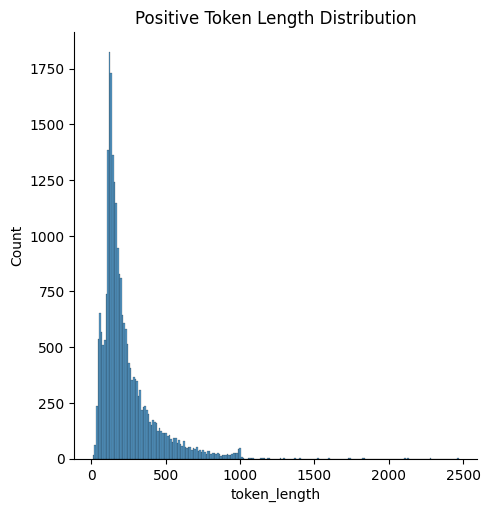

In [8]:
plt.figure.Figure(figsize=(5, 8))
sns.displot(data_pos, x="token_length")
plt.pyplot.title("Positive Token Length Distribution")
plt.pyplot.show()

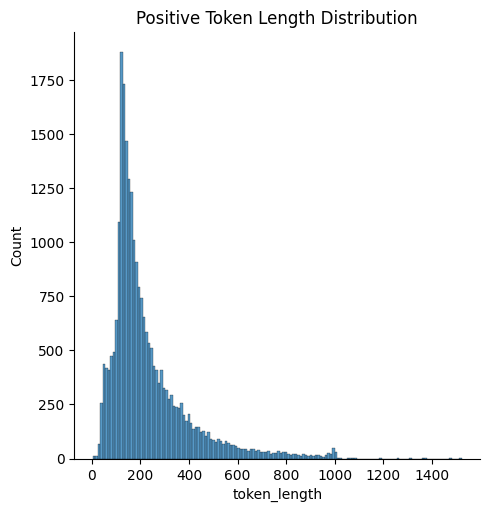

In [9]:
plt.figure.Figure(figsize=(5, 8))
sns.displot(data_neg, x="token_length")
plt.pyplot.title("Positive Token Length Distribution")
plt.pyplot.show()

In [10]:
print("Positive")
print(data_pos[data_pos["token_length"] == data_pos["token_length"].min()]["review"].item())
print()
print("Negative")
print(data_neg[data_neg["token_length"] == data_neg["token_length"].min()]["review"].item())

Positive
Brilliant and moving performances by Tom Courtenay and Peter Finch.

Negative
Primary plot!Primary direction!Poor interpretation.


# Очистка и предобработка

1. Создадим пайплай очистки текста
2. Создадим пайплайн предварительной обработки текста
3. Сохраним предобработанные данные в виде нового CSV-файле.

In [11]:
def rm_link(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

def rm_punct2(text):
    return re.sub (r'[\"\#\$\%\&\'\(\)\*\+\/\;\;\<\=\>\@\[\\\]\^\_\`\{\ /\}\~]', ' ', text)

def rm_html(text):
    return re.sub (r'<[^>]+>', '', text)

def space_bt_punct(text):
    pattern = r' ([.,!?-])'
    s = re.sub(pattern, r' \1', text)
    s = re.sub (r'\s{2,}', ' ', s)
    return s

def rm_number (text):
    return re.sub (r'\d+', '', text)

def rm_whitespaces (text):
    return re.sub (r' +', ' ', text)

def rm_nonascii(text):
    return re.sub (r'[^\x00-\x7f]', r'', text)

def rm_emoji(text):
    emojis = re.compile(
        '['
        u'\U0001F600-\U0001F64F'
        u'\U0001F300-\U0001F5FF'
        u'\U0001F680-\U0001F6FF'
        u'\U0001F1E0-\U0001F1FF'
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE
    )
    return emojis.sub(r'', text)

def spell_correction(text):
    return re.sub (r' (.)\1+', r'\1\1', text)


def clean_pipeline(text):
    no_link = rm_link(text)
    no_html = rm_html(no_link)
    space_punct = space_bt_punct(no_html)
    no_punct = rm_punct2(space_punct)
    no_number = rm_number(no_punct)
    no_whitespaces = rm_whitespaces(no_number)
    no_nonasci = rm_nonascii(no_whitespaces)
    no_emoji  = rm_emoji(no_nonasci)
    spell_corrected = spell_correction(no_emoji)
    return spell_corrected

In [12]:
def tokenize(text):
    return word_tokenize(text)

def rm_stopwords(text):
    return [i for i in text if i not in stop_words]

def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(t) for t in text]
    # make sure lemmas does not contains stopwords
    return rm_stopwords(lemmas)

def preprocess_pipeline(text):
    tokens = tokenize(text)
    no_stopwords = rm_stopwords(tokens)
    lemmas = lemmatize(no_stopwords)
    return ' '.join(lemmas)

In [13]:
data["clean"] = data["review"].progress_apply(clean_pipeline)
data["processed"] = data["clean"].progress_apply(preprocess_pipeline)
data.head()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [01:10<00:00, 705.47it/s]


,review,sentiment,label,token_length,clean,processed
0,One of the other reviewers has mentioned that ...,positive,1,307,One of the other reviewers has mentioned that ...,One reviewer mentioned watching Oz episode you...
1,A wonderful little production. <br /><br />The...,positive,1,162,A wonderful little production. The filming tec...,A wonderful little production . The filming te...
2,I thought this was a wonderful way to spend ti...,positive,1,166,I thought this was a wonderful way to spend ti...,I thought wonderful way spend time hot summer ...
3,Basically there's a family where a little boy ...,negative,0,138,Basically there s a family where a little boy ...,Basically family little boy Jake think zombie ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,230,Petter Mattei s Love in the Time of Money is a...,Petter Mattei Love Time Money visually stunnin...


In [14]:
data[["processed", "label"]].to_csv("./data/imbd_processed.csv", index=False, header=True)

# Подготовка датасета

К настоящему времени у нас уже есть обработанные даннеы. Прежде чем перейдем к этапу классификации, нам нужно преобразовать текст в векторыне представления (эмбеддинги). Для этого еам нужно создать словарь, который сопоставляет каждый токен с идентификаторами.

1. создадим словарь
2. закодируем отзывы
3. дополним короткие обзоры и обрежем длинные
4. разделим значения выборки на обучение / тест / валидацию
5. подготовим загрузчик данных и пакеты

In [2]:
data = pd.read_csv("./data/imbd_processed.csv")

for row in data[:2].iterrows():
    print(row[1]["processed"])
    print(f"Label: {row[1]['label']}")
    print('\n')

One reviewer mentioned watching Oz episode youll hooked . They right , exactly happened me.The first thing struck Oz brutality unflinching scene violence , set right word GO . Trust , show faint hearted timid . This show pull punch regard drug , sex violence . Its hardcore , classic use word.It called OZ nickname given Oswald Maximum Security State Penitentary . It focus mainly Emerald City , experimental section prison cell glass front face inwards , privacy high agenda . Em City home many .. Aryans , Muslims , gangsta , Latinos , Christians , Italians , Irish .... scuffle , death stare , dodgy dealing shady agreement never far away.I would say main appeal show due fact go show dare . Forget pretty picture painted mainstream audience , forget charm , forget romance ... OZ mess around . The first episode I ever saw struck nasty surreal , I say I ready , I watched , I developed taste Oz , got accustomed high level graphic violence . Not violence , injustice crooked guard wholl sold nick

In [3]:
reviews = data.processed.values
words = ' '.join(reviews)
words = words.split()

words[:10]

['One',
 'reviewer',
 'mentioned',
 'watching',
 'Oz',
 'episode',
 'youll',
 'hooked',
 '.',
 'They']

In [4]:
counter = Counter(words)
vocab = sorted(counter, key=counter.get, reverse=True)
int2word = dict(enumerate(vocab, 1))
int2word[0] = "<PAD>"
word2int = {word: _id for _id, word in int2word.items()}

In [5]:
reviews[0]

'One reviewer mentioned watching Oz episode youll hooked . They right , exactly happened me.The first thing struck Oz brutality unflinching scene violence , set right word GO . Trust , show faint hearted timid . This show pull punch regard drug , sex violence . Its hardcore , classic use word.It called OZ nickname given Oswald Maximum Security State Penitentary . It focus mainly Emerald City , experimental section prison cell glass front face inwards , privacy high agenda . Em City home many .. Aryans , Muslims , gangsta , Latinos , Christians , Italians , Irish .... scuffle , death stare , dodgy dealing shady agreement never far away.I would say main appeal show due fact go show dare . Forget pretty picture painted mainstream audience , forget charm , forget romance ... OZ mess around . The first episode I ever saw struck nasty surreal , I say I ready , I watched , I developed taste Oz , got accustomed high level graphic violence . Not violence , injustice crooked guard wholl sold nic

In [6]:
reviews_enc = [[word2int[word] for word in review.split()] for review in tqdm(reviews)]

for i in range(5):
    print(reviews_enc[i][:5])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:01<00:00, 31506.96it/s]

[221, 1054, 936, 83, 3707]
[61, 317, 58, 244, 2]
[3, 99, 317, 32, 1003]
[2685, 137, 58, 245, 3176]
[84822, 10536, 1078, 1924, 7544]


In [7]:
def pad_features(reviews, pad_id, seq_length=128):
    features = np.full((len(reviews), seq_length), pad_id, dtype=int)

    for i, row in enumerate(reviews):
        # if seq_lenght < len(row) then reviews will be trimmed
        features[i, :len(row)] = np.array(row)[:seq_length]

    return features


seq_length = 256
features = pad_features(reviews_enc, pad_id=word2int["<PAD>"], seq_length=seq_length)

assert len(features) == len(reviews_enc)
assert len(features[0]) == seq_length

features[:10, :10]

array([[  221,  1054,   936,    83,  3707,   184,   429,  2993,     2,
          120],
       [   61,   317,    58,   244,     2,     6,  1238,  1605, 84817,
        84818],
       [    3,    99,   317,    32,  1003,    12,   884,  1748,  2580,
            1],
       [ 2685,   137,    58,   245,  3176,    39,   660,  4316,   582,
          880],
       [84822, 10536,  1078,  1924,  7544,  2200,  1275,     5,    45,
            2],
       [ 2931,  3628,   360,     4,     1,    18, 45470,     1,  3008,
         7545],
       [    3,   198,    16,     9,    20, 12603,  1868, 62584,   131,
         7947],
       [   15,    31,   418,     1,  1318,  3926,   167,    35,  2920,
            2],
       [52127,   959,   352,     5,     3,   194,   820,    83,     5,
            2],
       [   76,     9,   122,  2507,  8863,  2024,     9,     4,     2,
           76]])

In [8]:
labels = data.label.to_numpy()
labels

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [9]:
train_size = .7
val_size = .5

split_id = int(len(features) * train_size)
train_x, remain_x = features[:split_id], features[split_id:]
train_y, remain_y = labels[:split_id], labels[split_id:]

split_val_id = int(len(remain_x) * val_size)
val_x, test_x = remain_x[:split_val_id], remain_x[split_val_id:]
val_y, test_y = remain_y[:split_val_id], remain_y[split_val_id:]

print("Feature Shapes:")
print('=' * 15)
print(f"Train set: {train_x.shape}")
print(f"Validation set: {val_x.shape}")
print(f"Test set: {test_x.shape}")

Feature Shapes:
Train set: (35000, 256)
Validation set: (7500, 256)
Test set: (7500, 256)


In [10]:
print(len(train_y[train_y == 0]), len(train_y[train_y == 1]))
print(len(val_y[val_y == 0]), len(val_y[val_y == 1]))
print(len(test_y[test_y == 0]), len(test_y[test_y == 1]))

17510 17490
3753 3747
3737 3763


In [11]:
batch_size = 128

trainset = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
validset = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
testset = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

trainloader = DataLoader(trainset, shuffle=True, batch_size=batch_size)
validloader = DataLoader(validset, shuffle=True, batch_size=batch_size)
testloader = DataLoader(testset, shuffle=True, batch_size=batch_size)

In [12]:
dataiter = iter(trainloader)
x, y = next(dataiter)

print("Sample batch size: ", x.size())
print("Sample batch input: \n", x)
print()
print("Sample label size: ", y.size())
print("Sample label input: \n", y)

Sample batch size:  torch.Size([128, 256])
Sample batch input: 
 tensor([[    3,   126,     4,  ...,     0,     0,     0],
        [  143,   563,    11,  ...,     0,     0,     0],
        [  243,    53,   445,  ...,   518,  1146,    35],
        ...,
        [    3,   472,  3436,  ...,     0,     0,     0],
        [   15, 44213,   337,  ...,     0,     0,     0],
        [   15,     4,     7,  ...,     0,     0,     0]], dtype=torch.int32)

Sample label size:  torch.Size([128])
Sample label input: 
 tensor([0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0,
        1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1,
        0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
        1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1,
        0, 1, 0, 1, 1, 1, 1, 1])


# Моделирование

что будем делать:
1. Создадим архитектуру нейронной сети
2. Определим гипер параметры модели
3. Настроим конфигурации обучения
4. Напишем цикл обучения-проверки
5. Нарисуем график изменения Loss
6. Вывод на тестовом наборе
7. Метрики оценки

In [77]:
class SentimentModel(nn.Module):
    def __init__(self, vocab_size, output_size, hidden_size=128, embedding_size=400, n_layers=2, dropout=0.2):

        super(SentimentModel, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, n_layers, dropout=dropout, batch_first=True)

        self.batch_norm = nn.BatchNorm1d(hidden_size, momentum=0.1)
        self.dropout = nn.Dropout(0.25)

        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # convert feature to long
        x = x.long()

        # map input to vector
        x = self.embedding(x)

        # pass forward to lstm
        o, _ = self.lstm(x)

        # get last sequence output
        o = o[:, -1, :]

        # apply dropout and fully connected layer
        o = self.batch_norm(o)
        o = self.dropout(o)
        o = self.fc(o)

        # sigoid
        o = self.sigmoid(o)

        return o


In [78]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [79]:
vocab_size = len(word2int)
output_size = 1
embedding_size = 256
hidden_size = 512
n_layers = 2
dropout = 0.25

model = SentimentModel(
    vocab_size,
    output_size,
    hidden_size,
    embedding_size,
    n_layers,
    dropout
)
print(model)

SentimentModel(
  (embedding): Embedding(206932, 256)
  (lstm): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.25)
  (batch_norm): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [120]:
lr = 0.001
# Specify L1 and L2 weights
l1_weight = 1.e-3
l2_weight = 1.e-4
criterion = nn.BCELoss()
optim = Adam(model.parameters(), lr=lr)#, weight_decay=1.0e-4)
grad_clip = 5
epochs = 14
print_every = 1
history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
    "epochs": epochs
}
es_limit = 5

In [121]:
  def compute_l1_loss(w):
      return torch.abs(w).sum()
  
  def compute_l2_loss(w):
      return torch.square(w).sum()

In [122]:
model = model.to(device)

epochloop = tqdm(range(epochs), position=0, desc="Training", leave=True)

# early stop trigger
es_trigger = 0
val_loss_min = torch.inf

for e in epochloop:
    # Training
    model.train()

    train_loss = 0
    train_acc = 0

    for id_, (feature, target) in enumerate(trainloader):
        epochloop.set_postfix_str(f"Training batch {id_}/{len(trainloader)}")

        feature, target = feature.to(device), target.to(device)

        optim.zero_grad()
        out = model(feature)

        predicted = torch.tensor([1 if i ==True else 0 for i in out > 0.5], device=device)
        equals = predicted == target
        acc = torch.mean(equals.type(torch.FloatTensor))
        train_acc += acc.item()

        loss = criterion(out.squeeze(), target.float())
      
        # Compute L1 and L2 loss component
        parameters = []
        for parameter in model.parameters():
            parameters.append(parameter.view(-1))
            
        l1 = l1_weight * compute_l1_loss(torch.cat(parameters))
        l2 = l2_weight * compute_l2_loss(torch.cat(parameters))
      
        # Add L1 and L2 loss components
        loss += l1
        loss += l2
        
        train_loss += loss.item()
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

        optim.step()

        del feature, target, predicted

    history["train_loss"].append(train_loss / len(trainloader))
    history["train_acc"].append(train_acc / len(trainloader))

    # Validation
    model.eval()

    val_loss = 0
    val_acc = 0

    with torch.no_grad():
        for id_, (feature, target) in enumerate(validloader):
            epochloop.set_postfix_str(f"Validation batch {id_}/{len(validloader)}")

            feature, target = feature.to(device), target.to(device)
            out = model(feature)

            predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
            equals = predicted == target
            acc = torch.mean(equals.type(torch.FloatTensor))
            val_acc += acc.item()

            loss = criterion(out.squeeze(), target.float())

            # Compute L1 and L2 loss component
            parameters = []
            for parameter in model.parameters():
                parameters.append(parameter.view(-1))
                
            l1 = l1_weight * compute_l1_loss(torch.cat(parameters))
            l2 = l2_weight * compute_l2_loss(torch.cat(parameters))
      
            # Add L1 and L2 loss components
            loss += l1
            loss += l2
        
            val_loss += loss.item()

            del feature, target, predicted


    history["val_loss"].append(val_loss / len(validloader))
    history["val_acc"].append(val_acc / len(validloader))


    # Возвращаем модель в режим обучения
    model.train()

    info_str = f"Val Loss: {val_loss / len(validloader):.3f} "
    info_str += f"| Val Acc: {val_acc / len(validloader):.3f}"
    epochloop.set_postfix_str(info_str)

    if (e + 1) % print_every == 0:
        info_str = f"Epoch {e+1}/{epochs} | Train Loss: {train_loss / len(trainloader):.3f} "
        info_str += f"Train Acc: {train_acc / len(trainloader):.3f} "
        info_str += f"| Val Loss: {val_loss / len(validloader):.3f} "
        info_str += f"Val Acc: {val_acc / len(validloader):.3f}"

        epochloop.write(info_str)
        epochloop.update()

    if val_loss / len(validloader) <= val_loss_min:
        torch.save(model.state_dict(), "./sentiment_lstm.pt")
        val_loss_min = val_loss / len(validloader)
        es_trigger = 0
    else:
        info_str = "[WARNING] Validation loss did not improved ("
        info_str += f"{val_loss_min:.3f} --> {val_loss / len(validloader):.3f})"

        epochloop.write(info_str)
        es_trigger += 1

    if es_trigger >= es_limit:
        epochloop.write(f"Early stopped at Epoch {e+1}")
        history["epochs"] = e + 1
        break

Training:   7%|████████                                                                                                         | 1/14 [00:36<08:00, 36.96s/it, Val Loss: 10.693 | Val Acc: 0.869]

Epoch 1/14 | Train Loss: 12.082 Train Acc: 0.895 | Val Loss: 10.693 Val Acc: 0.869


Training:  21%|████████████████████████▍                                                                                         | 3/14 [01:15<04:40, 25.52s/it, Val Loss: 9.875 | Val Acc: 0.870]

Epoch 2/14 | Train Loss: 9.953 Train Acc: 0.904 | Val Loss: 9.875 Val Acc: 0.870


Training:  36%|█████████████████████████████████████████████                                                                                 | 5/14 [01:53<04:35, 30.56s/it, Training batch 2/274]

Epoch 3/14 | Train Loss: 10.544 Train Acc: 0.904 | Val Loss: 12.855 Val Acc: 0.867
[WARNING] Validation loss did not improved (9.875 --> 12.855)


Training:  43%|██████████████████████████████████████████████████████                                                                        | 6/14 [02:30<03:13, 24.15s/it, Training batch 2/274]

Epoch 4/14 | Train Loss: 11.090 Train Acc: 0.906 | Val Loss: 10.348 Val Acc: 0.868
[WARNING] Validation loss did not improved (9.875 --> 10.348)


Training:  57%|████████████████████████████████████████████████████████████████████████                                                      | 8/14 [03:07<02:46, 27.74s/it, Training batch 1/274]

Epoch 5/14 | Train Loss: 10.501 Train Acc: 0.908 | Val Loss: 12.973 Val Acc: 0.817
[WARNING] Validation loss did not improved (9.875 --> 12.973)


Training:  64%|█████████████████████████████████████████████████████████████████████████████████                                             | 9/14 [03:45<01:58, 23.73s/it, Training batch 2/274]

Epoch 6/14 | Train Loss: 11.963 Train Acc: 0.908 | Val Loss: 14.590 Val Acc: 0.872
[WARNING] Validation loss did not improved (9.875 --> 14.590)


Training:  43%|████████████████████████████████████████████████▍                                                                | 6/14 [04:21<05:49, 43.66s/it, Val Loss: 12.727 | Val Acc: 0.879]

Epoch 7/14 | Train Loss: 11.159 Train Acc: 0.907 | Val Loss: 12.727 Val Acc: 0.879
[WARNING] Validation loss did not improved (9.875 --> 12.727)
Early stopped at Epoch 7


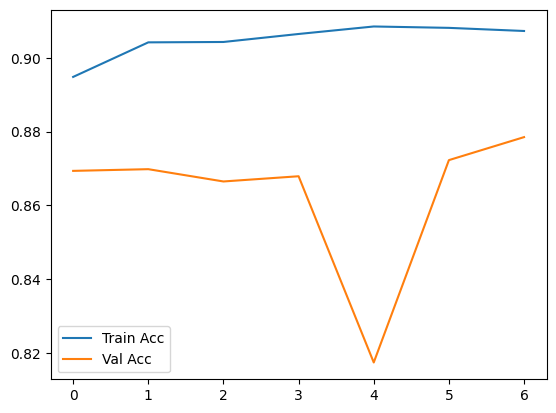

In [123]:
plt.figure.Figure(figsize=(6, 6))
plt.pyplot.plot(range(history["epochs"]), history["train_acc"], label="Train Acc")
plt.pyplot.plot(range(history["epochs"]), history["val_acc"], label="Val Acc")
plt.pyplot.legend()
plt.pyplot.show()

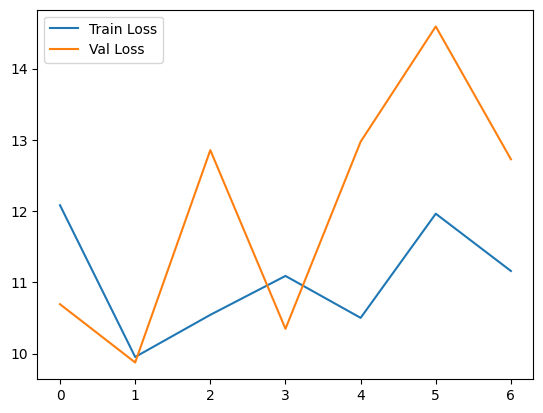

In [124]:
plt.figure.Figure(figsize=(6, 6))
plt.pyplot.plot(range(history["epochs"]), history["train_loss"], label="Train Loss")
plt.pyplot.plot(range(history["epochs"]), history["val_loss"], label="Val Loss")
plt.pyplot.legend()
plt.pyplot.show()

In [125]:
model.eval()

# metrics
test_loss = 0
test_acc = 0

all_target = []
all_predicted = []

testloop = tqdm(testloader, leave=True, desc="Inference")
with torch.no_grad():
    for feature, target in testloop:
        feature, target = feature.to(device), target.to(device)

        out = model(feature)

        predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
        equals = predicted == target
        acc = torch.mean(equals.type(torch.FloatTensor))
        test_acc += acc.item()

        loss = criterion(out.squeeze(), target.float())
        test_loss += loss.item()

        all_target.extend(target.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())


print(f"Accuracy {test_acc / len(testloader):.4f}, Loss: {test_loss / len(testloader):.4f}")

Inference: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:02<00:00, 21.51it/s]

Accuracy 0.8718, Loss: 0.3124


# Оценка качества

In [126]:
print(classification_report(all_predicted, all_target))

              precision    recall  f1-score   support

           0       0.90      0.85      0.88      3972
           1       0.84      0.90      0.87      3528

    accuracy                           0.87      7500
   macro avg       0.87      0.87      0.87      7500
weighted avg       0.87      0.87      0.87      7500



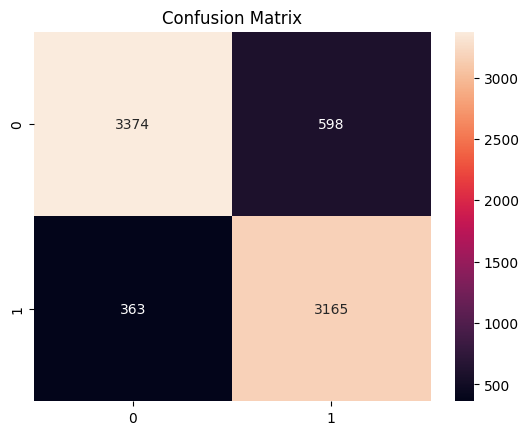

In [127]:
cm = confusion_matrix(all_predicted, all_target)
plt.figure.Figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="g")
plt.pyplot.title("Confusion Matrix")
plt.pyplot.show()